## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
import odc.geo.xr
from tqdm import tqdm
from odc.algo import mask_cleanup, xr_quantile
from concurrent.futures import ProcessPoolExecutor

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides
from intertidal.elevation import (
    load_data,
    ds_to_flat,
    pixel_rolling_median,
    pixel_dem,
    elevation,
)
from intertidal.utils import load_config

# cluster = create_dask_gateway_cluster(profile="r5_4XL", workers=10)
# print("Dashboard", cluster.dashboard_link)
# client = cluster.get_client()

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 94,Total memory: 697.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46089,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 94
Started: Just now,Total memory: 697.21 GiB
Comm: tcp://127.0.0.1:38463,Total threads: 94
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/34351/status,Memory: 697.21 GiB
Nanny: tcp://127.0.0.1:34255,


## Setup


### Set analysis parameters

In [21]:
study_area = 136
start_year = 2020
end_year = 2022
resolution = 10
crs = "EPSG:3577"
ndwi_thresh = 0.1
include_s2 = True
include_ls = True
filter_gqa = False

# Load analysis params from config file
config = load_config(
    config_path='configs/dea_intertidal_config.yaml')

### Load study area grid cell

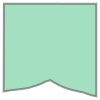

In [22]:
fname = f"{study_area}_{start_year}-{end_year}"

# Albers grid cells used to process the analysis
gridcell_gdf = (
    gpd.read_file(config['Input files']['grid_path']).to_crs(
        epsg=4326).set_index('id'))
gridcell_gdf.index = gridcell_gdf.index.astype(int).astype(str)
gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]

# Create geom as input for dc.load
geom = Geometry(geom=gridcell_gdf.iloc[0].geometry, crs='EPSG:4326')
geom

In [24]:
dem_ds = elevation(study_area=study_area)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/40181/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/40181/status,Workers: 1
Total threads: 94,Total memory: 697.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42035,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/40181/status,Total threads: 94
Started: Just now,Total memory: 697.21 GiB
Comm: tcp://127.0.0.1:43203,Total threads: 94
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/46011/status,Memory: 697.21 GiB
Nanny: tcp://127.0.0.1:33357,


2023-03-22 04:24:30 INFO Study area 136: Loaded study area grid
2023-03-22 04:24:30 INFO Study area 136: Loading satellite data
Task was destroyed but it is pending!
task: <Task pending name='Task-963778' coro=<RequestHandler._execute() running at /env/lib/python3.8/site-packages/tornado/web.py:1713> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fca46f50280>()]> cb=[_HandlerDelegate.execute.<locals>.<lambda>() at /env/lib/python3.8/site-packages/tornado/web.py:2361]>


Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 461/461 [00:46<00:00,  9.87it/s]
2023-03-22 04:32:16 INFO Study area 136: Masking nodata and adding tide heights to satellite data array
2023-03-22 04:32:41 INFO Study area 136: Flattening satellite data array and filtering to tide influenced pixels
2023-03-22 04:34:48 INFO Study area 136: Running per-pixel rolling median


Reducing analysed pixels from 10047939 to 473948 (4.72%)


100%|██████████| 114/114 [08:14<00:00,  4.34s/it]
2023-03-22 04:43:30 INFO Study area 136: Modelling intertidal elevation and confidence


Processing dem_low
Processing dem
Processing dem_high

Exporting GeoTIFF files to 'data/interim/pixel_136_2020-2022_....tif'


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-03-22 04:43:38 INFO Study area 136: Successfully completed intertidal elevation modelling


##### Other options for loading study area

In [25]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4)


Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [ ]:
dem_ds = elevation(study_area=geom,
                   start_year = 2015,
                   end_year = 2017)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/45463/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/45463/status,Workers: 1
Total threads: 94,Total memory: 697.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33719,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/45463/status,Total threads: 94
Started: Just now,Total memory: 697.21 GiB
Comm: tcp://127.0.0.1:45969,Total threads: 94
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/32957/status,Memory: 697.21 GiB
Nanny: tcp://127.0.0.1:40513,


2023-03-22 05:38:13 INFO Study area testing: Loaded custom study area
2023-03-22 05:38:13 INFO Study area testing: Loading satellite data
2023-03-22 05:39:38 INFO Study area testing: Modelling tide heights for each pixel


Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 274/274 [00:01<00:00, 172.84it/s]
2023-03-22 05:40:05 INFO Study area testing: Masking nodata and adding tide heights to satellite data array
2023-03-22 05:40:06 INFO Study area testing: Flattening satellite data array and filtering to tide influenced pixels
2023-03-22 05:40:11 INFO Study area testing: Running per-pixel rolling median


Reducing analysed pixels from 683520 to 84073 (12.30%)


 32%|███▏      | 37/114 [00:17<00:35,  2.15it/s]

## Load data

In [12]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46089,Workers: 0
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 0
Started: 28 minutes ago,Total memory: 0 B


In [19]:
ds = load_data(dc=dc, 
               geom=geom, 
               time_range=(str(start_year), str(end_year)), 
               resolution=resolution, 
               crs=crs,
               s2_prod="s2_nbart_ndwi" if include_s2 else None,
               ls_prod="ls_nbart_ndwi" if include_ls else None,
               config_path=config['Virtual product']['virtual_product_path'],
               filter_gqa=filter_gqa)[['ndwi']]
ds

<xarray.Dataset>
Dimensions:      (time: 353, y: 3139, x: 3201)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-07T01:30:39.609305 ... 2022-12...
  * y            (y) float64 -1.28e+06 -1.28e+06 ... -1.311e+06 -1.311e+06
  * x            (x) float64 -3.200e+04 -3.2e+04 -3.198e+04 ... -25.0 -15.0 -5.0
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
# Load into memory
ds.load()

## Pixel-based tides

In [ ]:
# Model tides into every pixel in the three-dimensional (x by y by time) satellite dataset
ds["tide_m"], _ = pixel_tides(ds, resample=True)

# Set tide array pixels to nodata if the satellite data array pixels contain
# nodata. This ensures that we ignore any tide observations where we don't
# have matching satellite imagery 
ds["tide_m"] = ds["tide_m"].where(~ds.to_array().isel(variable=0).isnull())

## Pixel-based DEM creation

### Flatten array from 3D to 2D and drop pixels with no correlation with tide
Flatten array to only pixels with positive correlations between water observations and tide height. This greatly improves processing time by ensuring only a narrow strip of pixels along the coastline are analysed, rather than the entire x * y array:


![](../data/figures/tide_array_flattening.JPG)

In [ ]:
ds_flat, freq, good_mask = ds_to_flat(
    ds, ndwi_thresh=0.0, min_freq=0.01, max_freq=0.99, min_correlation=0.2
)

### Pixel-wise rolling median
To conduct a pixel-wise rolling median, we first need to calculate some statistics on the tides observed for each individual pixel in the study area. These are then used to calculate rolling windows that are unique/tailored for the tidal regime of each pixel:

* `window_radius_tide`: Provides the radius/width of each rolling window in tide units (e.g. metres). 
* `window_spacing_tide`: Provides the spacing of each rolling window interval in tide units (e.g. metres)
* `window_offset`: Ensures that analysis covers the entire tide range by starting the first rolling window beneath the lowest tide, and finishing the final rolling window after the highest tide

In [ ]:
interval_ds = pixel_rolling_median(
    ds_flat, windows_n=100, window_prop_tide=0.15, max_workers=64
)

### Model intertidal elevation and confidence

In [ ]:
dem_ds = pixel_dem(interval_ds, ds, ndwi_thresh, fname)

### Plot output


In [ ]:
from matplotlib.colors import LightSource, Normalize
import matplotlib.pyplot as plt

# Create hillsahde based on the array
ls = LightSource(azdeg=315, altdeg=45)
dyx = 10
shade = ls.hillshade(dem_ds.dem.values, vert_exag=100, dx=dyx, dy=dyx, fraction=1.0)

(dem_ds.dem * shade).plot(cmap='viridis', vmin=-0.8, vmax=0.3, size=10)


## Experimental - not tested or working

In [ ]:
# # Clean data using morphological opening to remove narrow inland 
# # streams and waterbodies
# clean=[("opening", 20), ("dilation", 10)]
# to_keep = mask_cleanup(extents_da < 100, mask_filters=clean)
# dem_clean = dem.where(to_keep)

# # Export to file
# dem_clean.odc.write_cog(
#         fname=f"data/interim/pixel_{fname}_{suffix}_cleaned.tif", overwrite=True
#     )

In [ ]:
# test = ds.tide_m.mean(dim=['x', 'y'])

### Remove water not attached to ocean

In [ ]:
# from skimage.measure import label, regionprops

In [ ]:
# # First, break boolean array into unique, discrete regions/blobs
# blobs = xr.apply_ufunc(label, to_keep, 0, False, 1)

# # Get blob ID for each blob inside ocean area
# ocean = dc.load(product="geodata_coast_100k", like=ds.odc.geobox.compat).land == 0
# ocean_blobs = np.unique(blobs.where(ocean, 0))

# # Return only blobs that contained tide modelling point
# ocean_mask = blobs.isin(ocean_blobs[ocean_blobs != 0])

In [ ]:
# ocean_mask.plot()

In [ ]:
# # First, break boolean array into unique, discrete regions/blobs
# blobs = xr.apply_ufunc(label, ds, 1, False, 1)

# # Get blob ID for each tidal modelling point
# x = xr.DataArray(tide_points_gdf.geometry.x, dims="z")
# y = xr.DataArray(tide_points_gdf.geometry.y, dims="z")
# ocean_blobs = np.unique(blobs.interp(x=x, y=y, method="nearest"))

# # Return only blobs that contained tide modelling point
# ocean_mask = blobs.isin(ocean_blobs[ocean_blobs != 0])

# # Dilate mask so that we include land pixels on the inland side
# # of each shoreline to ensure contour extraction accurately
# # seperates land and water spectra
# if dilation:
#     ocean_mask = xr.apply_ufunc(binary_dilation, ocean_mask, disk(dilation))

# return ocean_mask

### Regression experiment

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
ds_subset = interval_ds.where((interval_ds.ndwi > 0.05) & (interval_ds.ndwi < 0.25))
linreg = lag_linregress_3D(x=ds_subset.tide_m, y=ds_subset.ndwi, first_dim='interval')

In [ ]:
# linreg.intercept.unstack("z").reindex_like(ds).plot(robust=True)

In [ ]:
# linreg.slope.unstack("z").reindex_like(ds).plot(robust=True)

In [ ]:
testing = ((0 - linreg.intercept) / linreg.slope).where(linreg.pval < 0.01).unstack("z").reindex_like(ds)  #.plot.imshow(vmin=-1, vmax=0.5)

In [ ]:
testing = testing.where(testing > ds_subset.tide_m.min())

In [ ]:
testing.T.odc.write_cog(fname=f'data/interim/pixel_linreg7.tif', overwrite=True)

In [ ]:
y = mx + a
(y - a) / m

In [ ]:
ds.geobox

In [ ]:
quantile_ds.tide_m.where(quantile_ds.ndwi <= 0.1).dropna(dim='z', how='all')

In [ ]:
(tide_argmax + 1).unstack("z").reindex_like(ds).T.plot()

In [ ]:
tide_dry.isel(interval=(tide_argmax - 1).clip(0, len(tide_dry.interval) - 1))

In [ ]:
tide_dry.isel(tide_argmax)

In [ ]:
tide_argmax + 1

In [ ]:
tide_dry.dropna(dim='interval', how='all').argmax(dim='interval', axis=1)

In [ ]:
interval_ds

In [ ]:
# # Output name
# fname = 'testing1'
# # fname = aoi.lower().replace(' ', '')

# # Calculate 
# confidence = interval_ds.ndwi_std.mean(dim='interval')
# min_thresh = (0 - 0.5 * confidence)
# max_thresh = (0 + 0.5 * confidence)

# for thresh_name, thesh in {'': 0, '_low': min_thresh, '_high': max_thresh}.items():
    
#     dem_fname = f'data/interim/pixel_dem_{fname}{thresh_name}.tif'
#     print(f'Exporting {dem_fname}')
    
#     # Identify the max tide per pixel where NDWI == land
#     tide_thresh = interval_ds.tide_m.where(interval_ds.ndwi <= thesh).max(dim='interval')
#     tide_max = interval_ds.tide_m.max(dim='interval')
    
#     # Remove any pixel where tides max out (i.e. always land)
#     dem = tide_thresh.where(tide_thresh < tide_max)
    
#     # Export DEM file  
# #     dem.T.odc.write_cog(fname=dem_fname, overwrite=True)
#     dem.where(~((freq > 0) & tide_thresh.isnull()), dem.min()).T.odc.write_cog(fname=dem_fname, overwrite=True)
    

# # Export NDWI standard deviation/confidence file
# confidence.T.odc.write_cog(fname=f'data/interim/pixel_dem_{fname}_confidence.tif', overwrite=True)

In [ ]:
# dem.where(~((freq > 0) & tide_thresh.isnull()), dem.min()).plot()

In [ ]:
# dem.where(~(tide_thresh.isnull() & (freq > 0.90)), dem.min()).plot()

In [ ]:
interval_ds.squeeze('quantile').unstack().sel(x=x,  y=y, method='nearest')

In [ ]:
x, y = -1156521.12372093, 7712141.96160016
ndwi_thresh = 0.0

# Extract rolling and raw data
pixel_rolling = interval_ds.squeeze('quantile').unstack().sortby(["interval", "x", "y"]).sel(x=x,  y=y, method='nearest').to_dataframe().reset_index()
pixel_raw = ds.sel(x=x,  y=y, method='nearest').sortby('tide_m')
# pixel_raw['ndwi'] = (pixel_raw.ndwi > 0.1).where(~pixel_raw.ndwi.isnull())
# pixel_rolling = pixel_raw.rolling(time=100, min_periods=1).mean().to_dataframe().reset_index()
pixel_raw = pixel_raw.to_dataframe().reset_index()

# To plot
pixel_to_plot = pixel_rolling
pixel_to_plot_mean = pixel_to_plot.rolling(20, center=False, min_periods=None).mean()


# pixel_savgol = pixel_rolling.copy()
# pixel_savgol['ndwi'] = savgol_filter(pixel_savgol.ndwi.values, 50, 1)

# Calculate thresholds
land_tides = pixel_to_plot.where((pixel_to_plot.ndwi) < ndwi_thresh)
max_ind = land_tides.tide_m.argmax()


# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(x=pixel_raw.tide_m, y=pixel_raw.ndwi)
ax.plot(pixel_to_plot.tide_m, pixel_to_plot.ndwi, '-o', color='orange')
ax.plot(pixel_to_plot_mean.tide_m, pixel_to_plot_mean.ndwi, '-o', color='green')
# ax.plot(pixel_savgol.tide_m, pixel_savgol.ndwi, '-o', color='blue')
tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)


# clipped = pixel_rolling.where((pixel_rolling.ndwi > 0) & (pixel_rolling.ndwi < 0.1)).dropna()

# ax.plot(clipped.tide_m, clipped.ndwi, '-o', color='green')
# from scipy import stats
# linreg = stats.linregress(x=clipped.tide_m, y=clipped.ndwi)
# x = np.linspace(pixel_raw.tide_m.min(), pixel_raw.tide_m.max())
# # ax.plot(x, [linreg.slope * i + linreg.intercept for i in x], color='green', linestyle='--')
# tide_thresh_3 = (ndwi_thresh - linreg.intercept) / linreg.slope

# rolling2 = pixel_raw.sort_values('tide_m').rolling(100, center=True, min_periods=1).median()
# ax.plot(rolling2.tide_m, rolling2.ndwi, '-o', color='red')



# tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
# tide_thresh_2 = pixel_rolling.tide_m.iloc[max_ind + 1]

# ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
# ax.axvline(tide_thresh_2, color='red', linestyle='--', lw=0.8, alpha=0.5)
# ax.axvline(tide_thresh_3, color='green', linestyle='--', lw=2, alpha=0.5)
# ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)

In [ ]:
x, y = 801144.14604825, 8189103.58475355
ndwi_thresh = 0.1

# Extract rolling and raw data
pixel_rolling = interval_ds.squeeze('quantile').unstack().sel(x=x,  y=y, method='nearest').to_dataframe().reset_index()
pixel_raw = ds.sel(x=x,  y=y, method='nearest').sortby('tide_m')
# pixel_raw['ndwi'] = (pixel_raw.ndwi > 0.1).where(~pixel_raw.ndwi.isnull())
# pixel_rolling = pixel_raw.rolling(time=100, min_periods=1).mean().to_dataframe().reset_index()
pixel_raw = pixel_raw.to_dataframe().reset_index()

# To plot
pixel_to_plot = pixel_rolling
pixel_to_plot_mean = pixel_to_plot.rolling(20, center=False, min_periods=None).mean()


# pixel_savgol = pixel_rolling.copy()
# pixel_savgol['ndwi'] = savgol_filter(pixel_savgol.ndwi.values, 50, 1)

# Calculate thresholds
land_tides = pixel_to_plot.where((pixel_to_plot.ndwi) < ndwi_thresh)
max_ind = land_tides.tide_m.argmax()


# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(x=pixel_raw.tide_m, y=pixel_raw.ndwi)
ax.plot(pixel_to_plot.tide_m, pixel_to_plot.ndwi, '-o', color='orange')
ax.plot(pixel_to_plot_mean.tide_m, pixel_to_plot_mean.ndwi, '-o', color='green')
# ax.plot(pixel_savgol.tide_m, pixel_savgol.ndwi, '-o', color='blue')
tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)

In [ ]:
(pixel_rolling.ndwi * (10* pixel_rolling.ndwi.abs())).plot()

In [ ]:
ds_sub = ds.sel(x=x,  y=y, method='nearest')


ds_sub.sel(time=(ds_sub.ndwi < 0) & (ds_sub.tide_m > 0.25)).time

In [ ]:
from scipy.signal import savgol_filter
yhat = savgol_filter(pixel_rolling.ndwi.values, 50, 2) # window size 51, polynomial order 3
plt.plot(yhat)

In [ ]:
test = np.array([-0.5, -0.2, -0.01, 0, 0.01, 0.2, 0.5])

In [ ]:
import scipy.stats
plt.plot(scipy.stats.norm.pdf(test, loc=0, scale=1))

In [ ]:
from skimage import exposure

In [ ]:
plt.plot(test)

In [ ]:
plt.plot(exposure.adjust_gamma(np.abs(test), 2))

In [ ]:



from scipy.signal import savgol_filter
yhat = savgol_filter(pixel_raw.ndwi.values, 25, 3) # window size 51, polynomial order 3

pixel_rolling.ndwi.plot()
plt.plot(yhat)

In [ ]:
pixel_raw.ndwi.plot()

In [ ]:
interval_ds.ndwi2

In [ ]:
clipped_test = pixel_rolling.where((pixel_rolling.ndwi > -0.1) & (pixel_rolling.ndwi < 0.1)).dropna().rolling(5, center=True).mean()
plt.plot(clipped_test.tide_m, clipped_test.ndwi, '-o', color='green')

diff = clipped_test.ndwi.diff() / clipped_test.ndwi.index.to_series().diff()
plt.plot(clipped_test.tide_m, diff, '-o', color='red')

plt.axvline(clipped_test.tide_m.iloc[diff.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)
plt.axhline(clipped_test.ndwi.iloc[diff.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)

In [ ]:
plt.plot(clipped_test.tide_m, clipped_test.ndwi, '-o', color='green')

In [ ]:
pdf = gaussian_kde(pixel_rolling.ndwi.values, bw_method=0.5, weights=scipy.stats.norm.pdf(pixel_rolling.ndwi.values, loc=0, scale=0.1))
x = np.linspace(-0.5, 0.5, 200)
y = pdf(x)
plt.axvline(x[y.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)
plt.plot(x, y, label='kde')

In [ ]:
from scipy.stats import gaussian_kde


In [ ]:
import scipy.stats
plt.scatter(pixel_rolling.ndwi.values, scipy.stats.norm.pdf(pixel_rolling.ndwi.values, loc=0, scale=0.1))

In [ ]:
pixel_raw.tide_m.min()

In [ ]:
pixel_raw.ndwi.plot.density(bw_method=0.05)

In [ ]:
pixel_rolling.ndwi.plot()
(pixel_rolling.ndwi.diff() / pixel_rolling.ndwi.index.to_series().diff()).plot()

In [ ]:
from scipy.signal import savgol_filter
w = savgol_filter(y.sort_values('ndwi').ndwi, 5, 2)
w

In [ ]:
y.sort_values('tide_m').ndwi

In [ ]:
# tide_thresh_2 = 


In [ ]:
pixel_rolling.where(pixel_rolling.ndwi < 0).tide_m.argmax()

In [ ]:
x, y = 642456.7107189415, 8275569.497920433
pixel = interval_ds.sel(x=x,  y=y, method='nearest')
df_median = pixel.to_dataframe().reset_index()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_m, y=df_median.ndwi)
tide_thresh_1 = df_median.where(df_median.ndwi < 0).tide_m.max()
tide_thresh_2 = df_median.where(df_median.ndwi > 0).tide_m.min()
ax.axvline((tide_thresh_1 + tide_thresh_2) / 2)
ax.axhline(0)

### Elevation calculation

In [ ]:
# Output name
fname = 'testing1'
# fname = aoi.lower().replace(' ', '')

# Calculate 
min_thresh = (0 - 0.5 * s2_stdev_mean)
max_thresh = (0 + 0.5 * s2_stdev_mean)

for thresh_name, thesh in {'': 0, '_low': min_thresh, '_high': max_thresh}.items():
    
    dem_fname = f'data/interim/pixel_dem_{fname}{thresh_name}.tif'
    print(f'Exporting {dem_fname}')
    
    # Identify the max tide per pixel where NDWI == land
    tide_thresh = ds.tide_m.where(s2_median <= thesh).max(dim='tide_n')
    tide_max = ds.tide_m.max(dim='tide_n')
    
    # Remove any pixel where tides max out (i.e. always land)
    dem = tide_thresh.where(tide_thresh < tide_max)
    
    # Export DEM file  
    dem.odc.write_cog(fname=dem_fname, overwrite=True)

# Export NDWI standard deviation/confidence file
s2_stdev_mean.odc.write_cog(fname=f'data/interim/pixel_dem_{fname}_confidence.tif', overwrite=True)

### Experimental

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
# reg = lag_linregress_3D(s2_rolling.tide_height, (s2_rolling > 0).where(~s2_rolling.isnull()), first_dim='tide_height')
# (reg.pval < 0.01).plot.imshow()

In [ ]:
# s2_rolling

In [ ]:
# test_min = tide_3d.where(s2_rolling >= 0).min(dim='tide_height')
# test_max = tide_3d.where(s2_rolling < 0).max(dim='tide_height')
# # dem = test_min.where(~test_max.isnull())
# dem = ((test_max + test_min) / 2.0)
# write_cog(dem, fname='pixel_dem_mccarthurriver.tif', overwrite=True)


In [ ]:
# out = xr.corr(s2_rolling, tide_3d)

In [ ]:
write_cog(test_max, fname='pixel_dem13.tif', overwrite=True)  # 

In [ ]:
x, y = 755234.5430086093, 8215882.783825266
# pixel = s2_rolling.sel(x=x,  y=y, method='nearest')
# df_median = pixel.to_dataframe()[['ndwi']].reset_index()

pixel = ds.sel(x=x,  y=y, method='nearest')
df = pixel.to_dataframe()[['ndwi']].reset_index()
df_median = df.rolling(100, min_periods=10, center=True).median()
df_std = df.rolling(100, min_periods=10, center=True).std()
std_mean = df_std.ndwi.mean()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_height, y=df_median.ndwi)
# ax.axvline(df_median.where(df_median.ndwi > 0).tide_height.min())
ax.axvline(df_median.where(df_median.ndwi < 0).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 + std_mean * 0.5)).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 - std_mean * 0.5)).tide_height.max())
ax.axhline(0)

In [ ]:
std_mean.ndwi

In [ ]:
df_median.where(df_median.ndwi < 0).tide_height.max()

In [ ]:
df_median.where(df_median.ndwi > 0).tide_height.min()

# Shut down cluster

In [ ]:
# from dask_gateway import Gateway
# gateway = Gateway()

# # Close any existing clusters
# cluster_names = gateway.list_clusters()
# if len(cluster_names) > 0:
#     print("Cluster(s) still running:", cluster_names)
#     for n in cluster_names:
#         cluster = gateway.connect(n.name)
#         cluster.shutdown()

In [ ]:
# cluster.shutdown()